# 🕒 Progetto Kaggle — Analisi vendite Amazon India

In questo notebook rispondo ad alcune domande di business sulle vendite Amazon in India usando un dataset da Kaggle.

**Domande guida:**
1. Qual è l'andamento mensile delle vendite?
2. Quali stati/città generano più ordini?
3. Quali categorie portano più ricavi?
4. Qual è la distribuzione dello stato degli ordini (delivered/cancelled/returned)?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Lettura robusta (mantengo tutto come stringa per evitare conversioni premature)
df_raw = pd.read_csv(
    "../data/archive/Amazon Sale Report.csv",
    engine="python",
    encoding="utf-8",
    dtype=str
)

# Normalizza nomi colonna (rimuove BOM/spazi)
df_raw.columns = df_raw.columns.str.replace('\ufeff', '', regex=False).str.strip()

print(f"Shape df_raw: {df_raw.shape}")
print("Colonne:", df_raw.columns.tolist())
display(df_raw.head(3))


Shape df_raw: (128975, 24)
Colonne: ['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel', 'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids', 'B2B', 'fulfilled-by', 'Unnamed: 22']


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.0,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.0,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN


In [2]:
# Copia di lavoro
df = df_raw.copy()

# Rimuove eventuale colonna 'index' creata in export
if 'index' in df.columns:
    df = df.drop(columns=['index'])

# (Ridondante ma innocuo) rinormalizza i nomi colonna
df.columns = df.columns.str.replace('\ufeff', '', regex=False).str.strip()

print(f"Shape df: {df.shape}")
print("Colonne df:", df.columns.tolist())
display(df.head(3))


Shape df: (128975, 23)
Colonne df: ['Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel', 'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids', 'B2B', 'fulfilled-by', 'Unnamed: 22']


,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,Size,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,INR,406.0,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,INR,329.0,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN


In [3]:
# Esempio: 04-30-22  ->  %m-%d-%y
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y', errors='coerce')

print("Date non nulle:", df['Date'].notna().sum())
display(df[['Date']].head())


Date non nulle: 128975


,Date
0,2022-04-30
1,2022-04-30
2,2022-04-30
3,2022-04-30
4,2022-04-30


In [4]:
# Converte Amount in numerico (valori non validi -> NaN)
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

print("Amount non null:", df['Amount'].notna().sum())
print(df['Amount'].describe())

Amount non null: 121180
count    121180.000000
mean        648.561465
std         281.211687
min           0.000000
25%         449.000000
50%         605.000000
75%         788.000000
max        5584.000000
Name: Amount, dtype: float64


Mesi nel trend: 4


Date
2022-03-01      101683.85
2022-04-01    28838708.32
2022-05-01    26226476.75
2022-06-01    23425809.38
Freq: MS, Name: Amount, dtype: float64

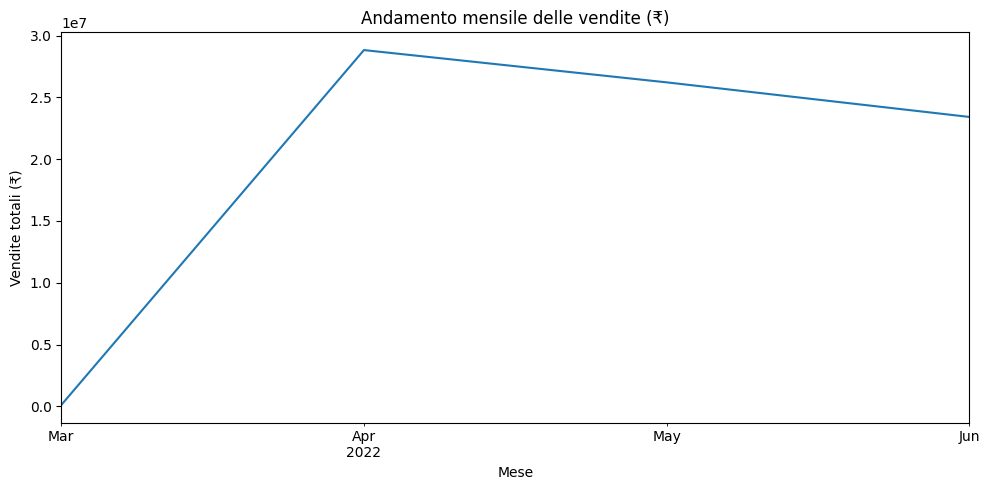

In [5]:
# Tieni solo righe con Date e Amount validi
valid = df[df['Date'].notna() & df['Amount'].notna()]

# Somma vendite per mese
sales_trend = valid.groupby(valid['Date'].dt.to_period('M'))['Amount'].sum()
sales_trend.index = sales_trend.index.to_timestamp()

print("Mesi nel trend:", len(sales_trend))
display(sales_trend.head())

# Plot
ax = sales_trend.plot(kind='line', figsize=(10, 5), title="Andamento mensile delle vendite (₹)")
ax.set_xlabel("Mese")
ax.set_ylabel("Vendite totali (₹)")
plt.tight_layout()
plt.show()

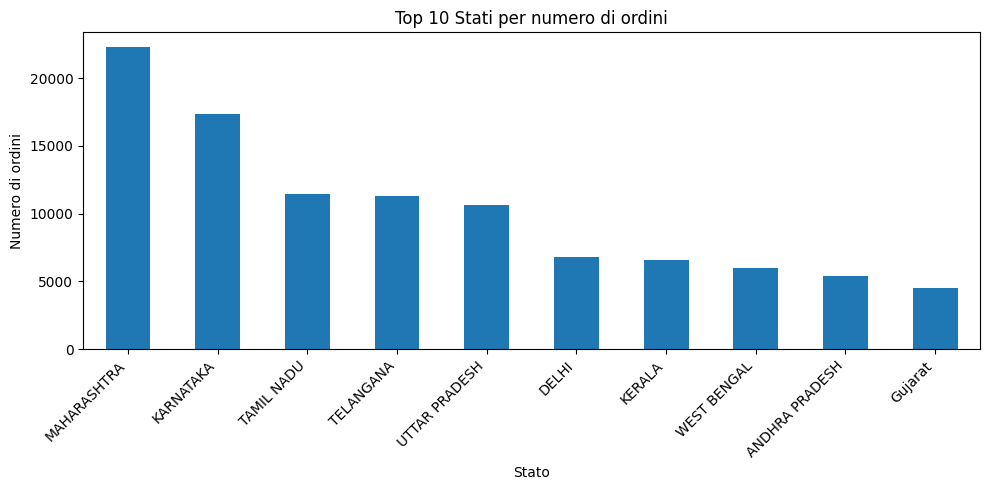

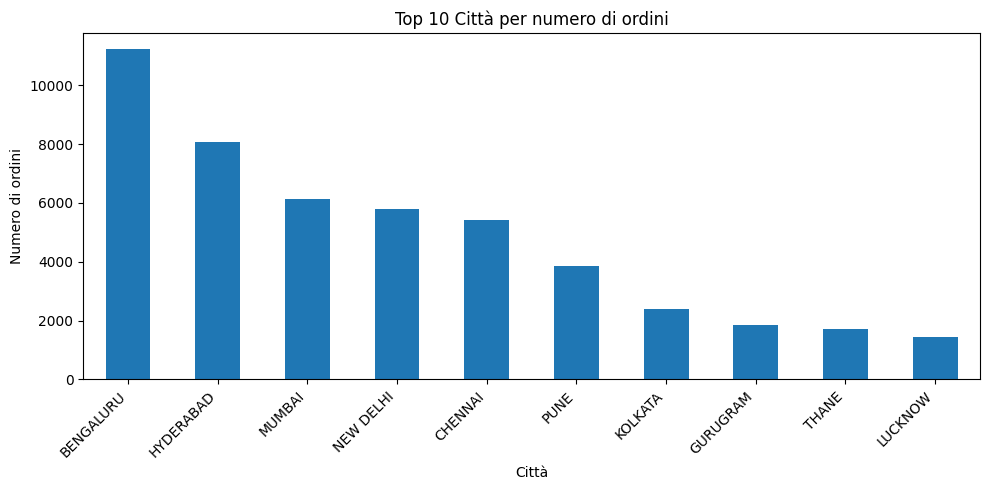

In [6]:
ax = (df['ship-state']
      .value_counts()
      .head(10)
      .plot(kind='bar', figsize=(10, 5), title="Top 10 Stati per numero di ordini"))
ax.set_xlabel("Stato")
ax.set_ylabel("Numero di ordini")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

ax = df['ship-city'].value_counts().head(10).plot(
    kind='bar', figsize=(10,5), title="Top 10 Città per numero di ordini"
)
ax.set_xlabel("Città")
ax.set_ylabel("Numero di ordini")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



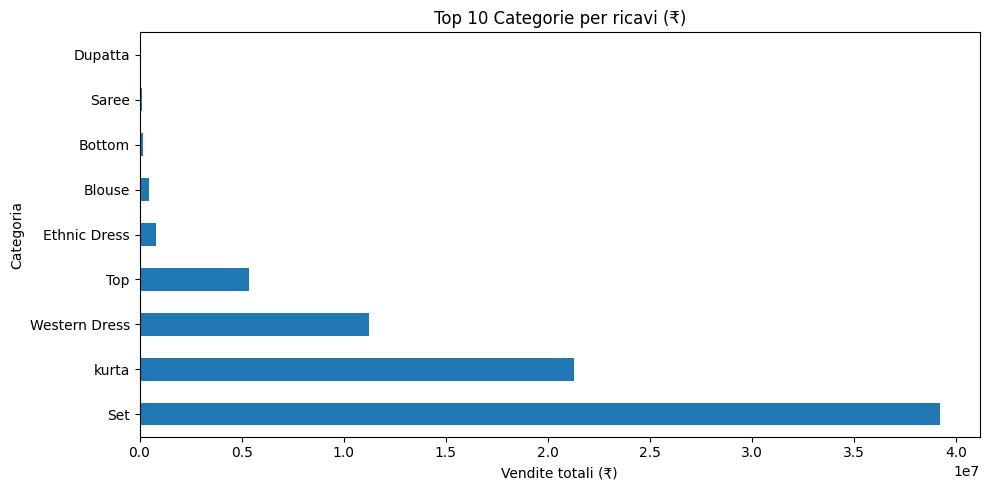

In [7]:
# Somma le vendite per categoria e ordinale
category_sales = (
    df.groupby('Category')['Amount']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

# Plot
ax = category_sales.plot(kind='barh', figsize=(10,5), title="Top 10 Categorie per ricavi (₹)")
ax.set_xlabel("Vendite totali (₹)")
ax.set_ylabel("Categoria")
plt.tight_layout()
plt.show()

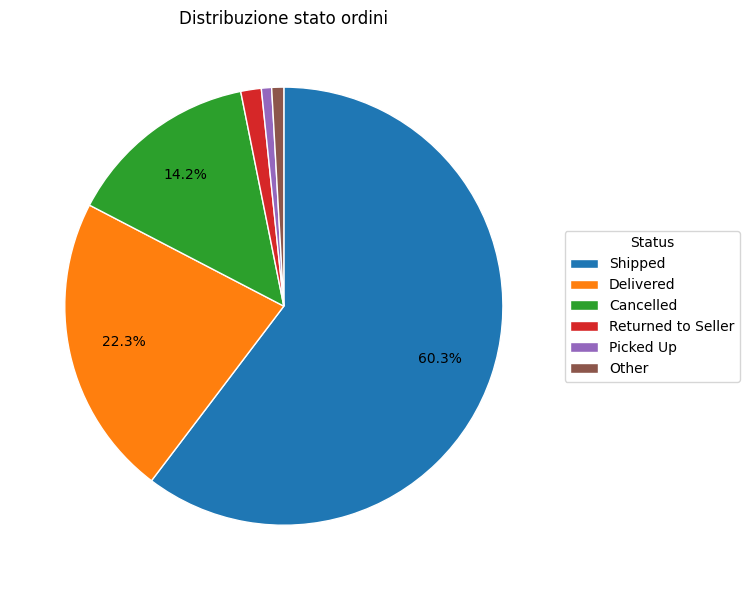

In [8]:
# 1) Normalizza/accorcia nomi lunghi (opzionale)
status_map = {
    "Shipped - Delivered to Buyer": "Delivered",
    "Shipped - Picked Up": "Picked Up",
    "Shipped - Returned to Seller": "Returned to Seller",
    "Shipped - Out for Delivery": "Out for Delivery",
    "Shipped - In Transit": "In Transit",
}
s = df['Status'].astype(str).str.strip().replace(status_map)

# 2) Top 5 + "Other"
counts = s.value_counts()
top = counts.head(5)
other = counts.iloc[5:].sum()
data = top if other == 0 else pd.concat([top, pd.Series({'Other': other})])

# 3) Pie: percentuali dentro, legenda fuori
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    data.values,
    startangle=90,
    counterclock=False,
    autopct=lambda p: f'{p:.1f}%' if p >= 2 else '',
    pctdistance=0.75,
    labeldistance=None,
    wedgeprops=dict(linewidth=1, edgecolor='white')
)
ax.set_title("Distribuzione stato ordini")
ax.legend(wedges, data.index, title="Status", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [9]:


# Cartella di output (puoi cambiarla)
out_dir = Path("outputs")
out_dir.mkdir(parents=True, exist_ok=True)

# --- 1) Assicurati di avere sales_trend / valid calcolati (fallback sicuro) ---
if 'valid' not in globals():
    valid = df[df['Date'].notna() & df['Amount'].notna()]

if 'sales_trend' not in globals():
    sales_trend = valid.groupby(valid['Date'].dt.to_period('M'))['Amount'].sum()
    sales_trend.index = sales_trend.index.to_timestamp()

# --- 2) LINE CHART: andamento mensile vendite ---
fig, ax = plt.subplots(figsize=(10, 5))
sales_trend.plot(kind='line', ax=ax, title="Andamento mensile delle vendite (₹)")
ax.set_xlabel("Mese")
ax.set_ylabel("Vendite totali (₹)")
fig.tight_layout()
fig_path_trend = out_dir / "trend_mensile_vendite.png"
fig.savefig(fig_path_trend, dpi=200)
plt.close(fig)

# --- 3) BAR CHART: top 10 stati per numero di ordini ---
top_states = df['ship-state'].value_counts().head(10)
fig, ax = plt.subplots(figsize=(10, 5))
top_states.plot(kind='bar', ax=ax, title="Top 10 Stati per numero di ordini")
ax.set_xlabel("Stato")
ax.set_ylabel("Numero di ordini")
plt.xticks(rotation=45, ha='right')
fig.tight_layout()
fig_path_states = out_dir / "top_stati_ordini.png"
fig.savefig(fig_path_states, dpi=200)
plt.close(fig)

# --- 4) PIE CHART: distribuzione stato ordini ---
status_map = {
    "Shipped - Delivered to Buyer": "Delivered",
    "Shipped - Picked Up": "Picked Up",
    "Shipped - Returned to Seller": "Returned to Seller",
    "Shipped - Out for Delivery": "Out for Delivery",
    "Shipped - In Transit": "In Transit",
}
s = df['Status'].astype(str).str.strip().replace(status_map)
counts = s.value_counts()
top = counts.head(5)
other = counts.iloc[5:].sum()
data = top if other == 0 else pd.concat([top, pd.Series({'Other': other})])

fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    data.values,
    startangle=90,
    counterclock=False,
    autopct=lambda p: f'{p:.1f}%' if p >= 2 else '',
    pctdistance=0.75,
    labeldistance=None,
    wedgeprops=dict(linewidth=1, edgecolor='white')
)
ax.set_title("Distribuzione stato ordini")
ax.legend(wedges, data.index, title="Status", loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig_path_pie = out_dir / "distribuzione_stato_ordini.png"
fig.savefig(fig_path_pie, dpi=200)
plt.close(fig)

# --- 5) ESPORT CSV: trend mensile, top stati, distribuzione status ---
(sales_trend.rename("Amount")
            .to_csv(out_dir / "sales_trend_mensile.csv", index_label="month"))

top_states.rename("orders").to_csv(out_dir / "top_stati_ordini.csv", index_label="ship_state")

(data.rename("orders")
     .to_csv(out_dir / "distribuzione_status_top5_other.csv", index_label="status"))

print("Salvati:")
print(" -", fig_path_trend)
print(" -", fig_path_states)
print(" -", fig_path_pie)
print(" -", out_dir / "sales_trend_mensile.csv")
print(" -", out_dir / "top_stati_ordini.csv")
print(" -", out_dir / "distribuzione_status_top5_other.csv")


Salvati:
 - outputs\trend_mensile_vendite.png
 - outputs\top_stati_ordini.png
 - outputs\distribuzione_stato_ordini.png
 - outputs\sales_trend_mensile.csv
 - outputs\top_stati_ordini.csv
 - outputs\distribuzione_status_top5_other.csv


## 💬 Conclusioni

- Le vendite aumentano da Marzo ad Aprile e diminuiscono da Aprile a Giugno.
- Maharashtra e Karnataka sono gli stati più forti per ordini.
- Le categorie top sono Set e Kurta.
- Il 22.3% degli ordini è consegnato, 14% cancellato, 60% spedito.